# MIDI music generation with GAN

Notebook presented for the A.A. 2024/2025 Deep Learning project.

Daniel Capannini - daniel.capannini@studio.unibo.it

In this notebook, GANs with different sized structures will be compared and the results obtained will be compared.

---

Below is the download of the dataset and installation of the libraries used.

In [ ]:
!pip install miditok
!pip install pretty_midi
!pip install -q gdown

In [2]:
import os
import shutil
from pathlib import Path
import numpy as np
from IPython.display import Audio, display
from miditok import REMI, TokenizerConfig
from pathlib import Path
from miditok.data_augmentation import augment_dataset
from miditok.utils import split_files_for_training
from random import shuffle
import json
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pretty_midi
import matplotlib.pyplot as plt
import glob
from collections import Counter
from scipy.special import rel_entr
import cupy as cp

np.random.seed(42)

## dataset

the dataset used is [MAESTRO dataset](https://magenta.withgoogle.com/datasets/maestro), which contains a collection of MIDIs from different piano performances.

New folder is created with all the MIDI files of the dataset.

In [ ]:
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
!unzip 'maestro-v3.0.0-midi.zip'
!rm 'maestro-v3.0.0-midi.zip'
dataset_path = "maestro-v3.0.0"

In [ ]:
destination_folder = "dataset_midi"
os.makedirs(destination_folder, exist_ok=True)

midi_paths = list(Path(dataset_path).resolve().glob("**/*.mid")) + \
             list(Path(dataset_path).resolve().glob("**/*.midi"))

print(f"Trovati {len(midi_paths)} file MIDI.")

for midi_path in midi_paths:
    filename = os.path.basename(midi_path)
    destination_path = os.path.join(destination_folder, filename)
    shutil.copy2(midi_path, destination_path)

print("Copia completata in 'dataset_midi'.")

midi_paths = [Path(os.path.join(destination_folder, os.path.basename(p))) for p in midi_paths]

Trovati 1276 file MIDI.
Copia completata in 'dataset_midi'.


## Data Analisis

A MIDI (Musical Instrument Digital Interface) file is a digital file format that stores instructions for playing music rather than the actual audio itself. Instead of containing recorded sound, a MIDI file includes data such as which notes are played, their duration, pitch, intensity, and the instruments to be used. This makes MIDI files very lightweight and versatile, as they can be played back on different devices and instruments, often sounding different depending on the sound library or synthesizer used.

Estimated time: 199.94214636968422


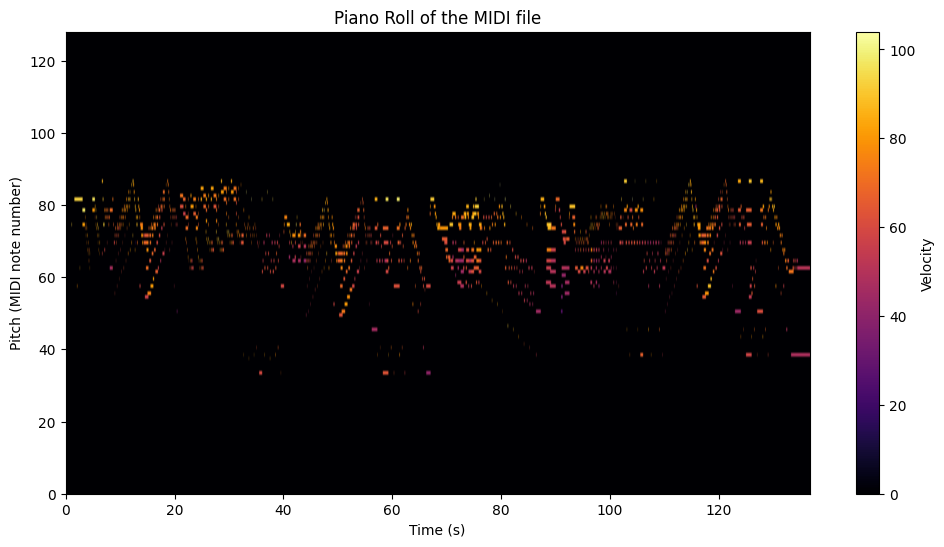

In [ ]:
midi = pretty_midi.PrettyMIDI("/content/dataset_midi/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1.midi")

print("Estimated time:", midi.estimate_tempo())

fs = 100
piano_roll = midi.get_piano_roll(fs=fs)

plt.figure(figsize=(12, 6))
plt.imshow(piano_roll[::-1], aspect='auto', cmap='inferno',
           extent=[0, piano_roll.shape[1]/fs, 0, 128])
plt.xlabel("Time (s)")
plt.ylabel("Pitch (MIDI note number)")
plt.title("Piano Roll of the MIDI file")
plt.colorbar(label="Velocity")
plt.show()


## Tokenizzazione

MIDI was not used directly for training, but was first tokenized using a tokenizer, which was trained below.

A tokenizer is a tool that converts raw MIDI data into a sequence of tokens that the AI ​​model can understand.

In the context of MIDI tokenization, each token represents a specific musical element or event, such as a note, velocity, or duration. These tokens serve as a "vocabulary" for the model, allowing it to learn and generate music.

In [ ]:
BEAT_RES = {(0, 1): 12, (1, 2): 4, (2, 4): 2, (4, 8): 1}
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": BEAT_RES,
    "num_velocities": 3,
    "special_tokens": ["BOS", "EOS"],
    "use_chords": True,
    "use_rests": True,
    "use_tempos": True,
    "num_tempos": 8,
    "tempo_range": (50, 200),
}

The pitch_range limits tokens to the realistic span of a piano, avoiding unnecessary notes. The beat_res dictionary defines different time resolutions across measures, ensuring fine rhythmic detail where it matters and coarser granularity elsewhere, which keeps the sequence length manageable. Velocity values are reduced to just three discrete levels, simplifying dynamics while preserving expressive contrast. Special tokens like BOS and EOS mark the start and end of sequences. Enabling chords, rests, and tempos provides richer musical structure, while the tempo values are quantized into eight categories within a practical BPM range. Altogether, these parameters create a compact yet musically meaningful vocabulary, making it easier for a model to learn and generate coherent music.

In [ ]:
midi_dir = Path(destination_folder)
midis = list(midi_dir.glob("**/*.mid")) + list(midi_dir.glob("**/*.midi"))

if not midis:
    raise FileNotFoundError("Nessun file MIDI trovato in 'dataset_midi'.")

##Train tokenizer

In [ ]:
config = TokenizerConfig(**TOKENIZER_PARAMS)

tokenizer = REMI(config)

vocab_size = 5000
tokenizer.train(vocab_size=vocab_size, files_paths=midis)
processed = [Path(f"{s}") for s in midis]
print(len(processed))

In [ ]:
tokenizer.save("tokenizerMIDI")

## download tokenizer

execute the next 2 cells to skip tokenizer training

In [ ]:
!gdown --id 12der1lMHfMyMbGWImONehL_43AoECyzB

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12der1lMHfMyMbGWImONehL_43AoECyzB
To: /content/tokenizer (2).json
100% 271k/271k [00:00<00:00, 125MB/s]


In [ ]:
tokenizer = REMI(params="tokenizer (2).json")

## Dataset preparation

organizes a MIDI dataset by collecting all MIDI files, splitting them into train/test subsets, and then applying preprocessing steps. Specifically, it chunks the training and test files into sequences suitable for modeling, applies data augmentation (pitch, velocity, duration variations), and finally reloads the processed files for each subset.

In [ ]:

base_dir = Path("/content/dataset_midi").resolve()

midis = list(base_dir.glob("**/*.mid")) + list(base_dir.glob("**/*.midi"))
midis = [midi.resolve() for midi in midis]

total_num_files = len(midis)
num_files_test = round(total_num_files * 0.20)

np.random.shuffle(midis)

midi_paths_test = midis[:num_files_test]
midi_paths_train = midis[num_files_test:]

train_dir = Path("dataset_train")
test_dir = Path("dataset_test")
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

for src_path in midi_paths_train:
    shutil.copy(src_path, train_dir / src_path.name)

for src_path in midi_paths_test:
    shutil.copy(src_path, test_dir / src_path.name)

for files_paths, subset_name in (
    (midi_paths_train, "train"),
    (midi_paths_test, "test")
):
    subset_chunks_dir = Path(f"Maestro_{subset_name}")

    split_files_for_training(
        files_paths=files_paths,
        tokenizer=tokenizer,
        save_dir=subset_chunks_dir,
        max_seq_len=1024,
        num_overlap_bars=2,
    )

    augment_dataset(
        subset_chunks_dir,
        pitch_offsets=[-12, 12],
        velocity_offsets=[-3, 3],
        duration_offsets=[-0.5, 0.5],
    )

midi_paths_train = list(Path("Maestro_train").glob("**/*.mid")) + list(Path("Maestro_train").glob("**/*.midi"))
midi_paths_test = list(Path("Maestro_test").glob("**/*.mid")) + list(Path("Maestro_test").glob("**/*.midi"))


Performing data augmentation: 100%|██████████| 2532/2532 [00:04<00:00, 558.05it/s]


In [ ]:
!zip -r dataset_train.zip dataset_train
!zip -r dataset_test.zip dataset_test

All MIDI files from the training and testing set are tokenized so they can be used to train the GAN.

In [ ]:
def midi_valid(midi) -> bool:
    if any(ts.numerator != 4 for ts in midi.time_signature_changes):
        return False  # time signature different from 4/*, 4 beats per bar
    return True

if os.path.exists("tokenized"):
  shutil.rmtree("tokenized")

for dir in ("train", "test"):
    tokenizer.tokenize_dataset(
        Path(f"Maestro_{dir}").resolve(),
        Path(f"tokenized_{dir}").resolve(),
        midi_valid,
    )

Tokenizing music files (content/tokenized_test): 100%|██████████| 15217/15217 [04:45<00:00, 53.36it/s]


In [ ]:
!zip -r tokenized_train.zip tokenized_train
!zip -r tokenized_test.zip tokenized_test

## download the tokenized dataset

In [ ]:
!gdown --id 1sYpjsu1Oheij9w4C0ssWgYNNebeLv-Zd
!gdown --id 1yENUMEQ-IIgBL1Kp-lhfTiab8A0XOjS8

!unzip tokenized_test.zip
!unzip tokenized_train.zip

## Read JSON

Here we read the produced JSON files containing the tokenization's output.

In [ ]:
def load_json(filepath: str) -> dict:
    """Load a JSON file and return its contents."""
    try:
        with open(filepath, "r") as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Skipping {filepath}: {e}")
        return None


def load_multiple_jsons(file_paths):
    """Load multiple JSON files into a list of objects."""
    results = []
    for fp in tqdm(file_paths, desc="Reading JSON files"):
        obj = load_json(fp)
        if obj is not None:
            results.append(obj)
    return results

train_jsons = Path("tokenized_train").resolve().rglob("*.json")
test_jsons = Path("tokenized_test").resolve().rglob("*.json")

train_data = load_multiple_jsons(train_jsons)
test_data = load_multiple_jsons(test_jsons)

if train_data and test_data:
    print(f"\nLoaded {len(train_data)} JSON files for training.")
else:
    print("Some JSON files could not be read.")


Reading JSON files: 58089it [00:10, 5441.91it/s]
Reading JSON files: 15217it [00:03, 4725.02it/s]


Loaded 58089 JSON files for training.


Rather than padding each MIDI file (converted into tokens) to a fixed length with special padding tokens, we instead concatenate the token IDs of all piano pieces into a single large Numpy array. This approach comes with trade-offs—most notably a loss of musical coherence when sequences are passed to the model and a weaker sense of each song as a complete unit—but it provides much greater flexibility in handling and processing the dat

In [ ]:
def extract_ids(data_objects):
    """Extract and convert token IDs from JSON objects."""
    arrays = []
    for obj in data_objects:
        if "ids" in obj and isinstance(obj["ids"], list) and len(obj["ids"]) > 0:
            arrays.append(np.asarray(obj["ids"][0], dtype=np.int32))
    return np.concatenate(arrays, axis=0)

all_ids_train = extract_ids(train_data)
all_ids_test = extract_ids(test_data)

## GAN model

The system is based on the structure of a Generative Adversarial Network (GAN) and consists of two main components:

Generator Network: a fully connected neural network that takes a random noise vector as input and produces a MIDI file as output (Generated MIDI). The generator's objective is to create data that closely mimics authentic data. This component embodies the creative aspect of the GAN architecture.

Discriminator Network: another fully connected neural network that receives as input both authentic MIDI files (from the Maestro Dataset) and MIDI files produced by the generator. The discriminator's function is to classify these inputs as either authentic (True) or synthetic (False). This component embodies the evaluative aspect of the GAN architecture.

Training process: The generator enhances its performance by attempting to fool the discriminator, creating data that the discriminator finds progressively more challenging to distinguish from authentic data. Simultaneously, the discriminator is optimized to become more precise at identifying the distinction between authentic and generated data. This adversarial process relies on a loss function calculated for both networks, with weight updates executed using the ADAM optimizer.

To evaluate performance variation in relation to model complexity, three generators and three discriminators were trained with the same overall architecture but varying sizes:

- Mini,
- Medium,
- Large.

These models share the same fundamental architecture but differ in the number of neurons and layers, enabling a comparative analysis of their performance in relation to representational capacity.

In [ ]:
class GeneratorMini(nn.Module):
    def __init__(self, noise_dim: int, hidden_dim: int, output_length: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, output_length),
            nn.Tanh()
        )

    def forward(self, noise_vector: torch.Tensor) -> torch.Tensor:
        return self.model(noise_vector)


class DiscriminatorMini(nn.Module):
    def __init__(self, input_length: int, hidden_dim: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_length, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 4, 1)
        )

    def forward(self, sequence: torch.Tensor) -> torch.Tensor:
        return self.model(sequence)


In [ ]:
class GeneratorMedium(nn.Module):
    def __init__(self, noise_dim: int, hidden_dim: int, output_length: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim * 8),
            nn.ReLU(),
            nn.Linear(hidden_dim * 8, hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, output_length),
            nn.Tanh()
        )

    def forward(self, noise_vector: torch.Tensor) -> torch.Tensor:
        return self.model(noise_vector)


class DiscriminatorMedium(nn.Module):
    def __init__(self, input_length: int, hidden_dim: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_length, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 4, hidden_dim * 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 8, 1)
        )

    def forward(self, sequence: torch.Tensor) -> torch.Tensor:
        return self.model(sequence)


In [ ]:
class GeneratorLarge(nn.Module):
    def __init__(self, noise_dim: int, hidden_dim: int, output_length: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim * 16),
            nn.ReLU(),
            nn.Linear(hidden_dim * 16, hidden_dim * 8),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 8, hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, output_length),
            nn.Tanh()
        )

    def forward(self, noise_vector: torch.Tensor) -> torch.Tensor:
        return self.model(noise_vector)


class DiscriminatorLarge(nn.Module):
    def __init__(self, input_length: int, hidden_dim: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_length, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 4, hidden_dim * 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 8, hidden_dim * 16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 16, 1)
        )

    def forward(self, sequence: torch.Tensor) -> torch.Tensor:
        return self.model(sequence)


## GAN class

This MidiGAN class implements the logic required to train a Generative Adversarial Network (GAN) composed of a generator and a discriminator. Both models are passed as arguments to the constructor, along with the input noise size, the length of the musical sequence, and the tokenizer used to manage the MIDI data. The class independently manages the optimizers, weight initialization, and loss function calculation, allowing the two models to be trained in a coordinated manner.

During training, the discriminator learns to distinguish between real MIDI files (from the dataset) and those generated by the generator, while the generator attempts to produce increasingly convincing sequences capable of fooling the discriminator. The class also manages alternating training strategies to balance the update steps of the two models and includes checks to avoid numerical instabilities such as NaN or Inf values.

It also provides methods to save the weights of the trained models, generate new sequences as numeric arrays, and convert them into real MIDI files, ready to be listened to and analyzed.

In [ ]:

class MidiGAN:
    def __init__(
        self,
        generator: nn.Module,
        discriminator: nn.Module,
        noise_dim: int,
        sequence_length: int,
        tokenizer,
        loss_fn: nn.Module = nn.BCEWithLogitsLoss(),
    ):
        self.generator = generator
        self.discriminator = discriminator
        self.noise_dim = noise_dim
        self.sequence_length = sequence_length
        self.loss_fn = loss_fn
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer)

        self.generator_optimizer = torch.optim.Adam(
            self.generator.parameters(), lr=0.00005, betas=(0.5, 0.999)
        )
        self.discriminator_optimizer = torch.optim.Adam(
            self.discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999)
        )

        self.generator.apply(self._init_weights)
        self.discriminator.apply(self._init_weights)

    def save(self, filepath: str):
        torch.save(
            {
                "generator": self.generator.state_dict(),
                "discriminator": self.discriminator.state_dict(),
            },
            filepath,
        )
        print(f"Generator + Discriminator weights saved to {filepath}")

    @staticmethod
    def load(
        generator_class,
        discriminator_class,
        filepath: str,
        noise_dim: int,
        sequence_length: int,
        tokenizer,
        map_location: str = "cpu",
        gen_kwargs={},
        disc_kwargs={},
    ):
        checkpoint = torch.load(filepath, map_location=map_location)
        generator = generator_class(**gen_kwargs)
        discriminator = discriminator_class(**disc_kwargs)
        generator.load_state_dict(checkpoint["generator"])
        discriminator.load_state_dict(checkpoint["discriminator"])
        print(f"Generator + Discriminator weights loaded from {filepath}")

        return MidiGAN(
            generator=generator,
            discriminator=discriminator,
            noise_dim=noise_dim,
            sequence_length=sequence_length,
            tokenizer=tokenizer,
        )

    def train(
        self,
        dataloader,
        epochs: int,
        device: torch.device,
        loss_delta: float = 0.7,
        steps_each_print: int = 5,
        advantage_steps: int = 2,
        alternate_training: bool = False,
        generator_steps: int = 1,
        discriminator_steps: int = 1,
    ):
        print(f"Starting training for {epochs} epochs")
        self.generator.to(device).train()
        self.discriminator.to(device).train()

        all_d_losses, all_g_losses = [], []

        for epoch in range(epochs):
            epoch_d_losses, epoch_g_losses = [], []
            pbar = tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{epochs}")
            for step, real_batch in enumerate(dataloader):
                batch_size = real_batch.size(0)
                real_batch = real_batch.to(device)

                d_loss, g_loss = self._train_batch(
                    batch_size, real_batch, device, generator_steps, discriminator_steps
                )
                all_d_losses.append(d_loss)
                all_g_losses.append(g_loss)
                epoch_d_losses.append(d_loss)
                epoch_g_losses.append(g_loss)

                if alternate_training:
                    if g_loss - d_loss > loss_delta:
                        generator_steps, discriminator_steps = advantage_steps, 1
                    elif d_loss - g_loss > loss_delta:
                        discriminator_steps, generator_steps = advantage_steps, 1
                    else:
                        generator_steps, discriminator_steps = 1, 1

                if (step + 1) % steps_each_print == 0:
                    desc = f"D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}"
                    if generator_steps != 1 or discriminator_steps != 1:
                        desc += f" | D Steps: {discriminator_steps}, G Steps: {generator_steps}"
                    pbar.set_description(desc)
                pbar.update(1)

            pbar.close()
            mean_d_loss = np.mean(epoch_d_losses)
            mean_g_loss = np.mean(epoch_g_losses)
            print(f"Epoch {epoch+1}/{epochs} | Mean D Loss: {mean_d_loss:.4f} | Mean G Loss: {mean_g_loss:.4f}")

        return all_d_losses, all_g_losses

    def _generator_train_step(self, batch_size: int, device: torch.device) -> float:
        self.generator.zero_grad()
        noise = self._sample_noise(batch_size, device)
        fake_data = self.generator(noise)
        fake_predictions = self.discriminator(fake_data)

        loss_g = -torch.mean(fake_predictions)
        if not (torch.isnan(loss_g) or torch.isinf(loss_g)):
            loss_g.backward()
            torch.nn.utils.clip_grad_norm_(self.generator.parameters(), max_norm=1.0)
            self.generator_optimizer.step()
        else:
            print("NaN or Inf detected in generator loss.")
        return loss_g.item()

    def _discriminator_train_step(
        self, batch_size: int, real_data: torch.Tensor, device: torch.device
    ) -> float:
        self.discriminator.zero_grad()
        noise = self._sample_noise(batch_size, device)
        fake_data = self.generator(noise)

        real_predictions = self.discriminator(real_data)
        fake_predictions = self.discriminator(fake_data)

        real_labels = torch.ones_like(real_predictions)
        fake_labels = torch.zeros_like(fake_predictions)

        loss_real = self.loss_fn(real_predictions, real_labels)
        loss_fake = self.loss_fn(fake_predictions, fake_labels)

        loss_d = loss_real + loss_fake
        if not (torch.isnan(loss_d) or torch.isinf(loss_d)):
            loss_d.backward()
            self.discriminator_optimizer.step()
        else:
            print("NaN or Inf detected in discriminator loss.")
        return loss_d.item()

    def _train_batch(
        self, batch_size: int, real_data: torch.Tensor, device: torch.device,
        generator_steps: int, discriminator_steps: int
    ):
        d_losses = [
            self._discriminator_train_step(batch_size, real_data, device)
            for _ in range(discriminator_steps)
        ]
        g_losses = [
            self._generator_train_step(batch_size, device)
            for _ in range(generator_steps)
        ]
        return np.mean(d_losses), np.mean(g_losses)

    def _init_weights(self, layer):
        if isinstance(layer, (nn.Linear, nn.Conv1d)):
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    def _sample_noise(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.randn(batch_size, self.noise_dim, device=device)

    def predict(self, n_samples: int, device: torch.device):
        noise = self._sample_noise(n_samples, device)
        return self.generator(noise).cpu().detach().numpy()

    def generate_midi(self, n_samples: int, output_prefix: str, device: torch.device):
        predictions = self.predict(n_samples, device)
        midpoint = self.vocab_size // 2
        predictions = [x * midpoint + midpoint for x in predictions]

        for i, pred in enumerate(predictions):
            tokens = pred.astype(np.int32)
            tokens[tokens == self.vocab_size] = 0
            try:
                midi_obj = self.tokenizer.decode([tokens])
                midi_obj.dump_midi(f"{output_prefix}_{i}.mid")
                print(f"MIDI generated: {output_prefix}_{i}.mid")
            except Exception as e:
                print(f"Error generating MIDI for sample {i}: {e}")


The TokenDataset class and the normalize_data function prepare the input data for GAN training. Specifically, TokenDataset defines a custom dataset containing token sequences (derived from the MIDI file) and makes them compatible with PyTorch, returning 32-bit floating-point numeric tensors, ready for use in data loaders. The normalize_data function, on the other hand, normalizes the token values ​​to a range between -1 and 1, so they better fit the generator's widely used activation function. This normalization step is crucial because it ensures numerical stability and speeds up convergence during training, reducing the risk of gradients that are too large or too small.

In [ ]:
class TokenDataset(Dataset):
    """Dataset of normalized token sequences for GAN training."""
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32)


def normalize_data(token_array, vocab_size: int):
    """
    Normalize input data to a interval = (-1, 1).
    """
    min_val, max_val = (-1, 1)
    normalized = (token_array - vocab_size / 2) / (vocab_size / 2)
    scaled = normalized * (max_val - min_val) / 2 + (max_val + min_val) / 2
    return scaled


Hyper-parameters kept unchanged for training each model:

- seq_length: This is the maximum length of the input or generated sequence. It allows the model to work on context windows of 512 steps, capturing temporal patterns or complex structures without exploding in memory.
- noise_dim: This is the size of the random vector that feeds the generator (latent input). It serves to introduce variability and creativity into the generated sequences, so that no two samples are the same.
- hidden_dim: This indicates the size of the network's hidden layers (generator and discriminator). A large value like 1536 increases the model's ability to represent complex structures and learn non-trivial relationships in the data.
- batch_size: batch size before weights update, values ​​like were also tested 64 and 256.

In [ ]:
vocab_size = len(tokenizer)
seq_length = 512
noise_dim = 512
hidden_dim = 1536
batch_size = 128

generator_config = {
    "noise_dim"  : noise_dim,
    "hidden_dim" : hidden_dim,
    "output_length" : seq_length
}


discriminator_config = {
    "input_length" : seq_length,
    "hidden_dim" : hidden_dim
}

## Trainig GAN Mini

## Setup for training

It then initializes the GAN generator and discriminator, configures the computing device (CPU or GPU), and prepares the data for training. Specifically, the MIDI tokens are normalized to the range
−1, 1, split into sequences of the desired length, and organized into a PyTorch dataset managed by DataLoader, which handles batching and shuffling. Finally, a quick test is performed on the GPU and the dataset information is printed to confirm that the system is ready for training.

This operation is also performed for training the other models.

In [ ]:

generator = GeneratorMini(**generator_config)
discriminator = DiscriminatorMini(**discriminator_config)

gan_params = {
    "generator"                : generator,
    "discriminator"            : discriminator,
    "noise_dim"                : noise_dim,
    "sequence_length"          : seq_length,
    "tokenizer"                : tokenizer,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0) if torch.cuda.is_available() else None

sequence_length = seq_length
batch_size = batch_size

vocab_size = len(tokenizer)
normalized_tokens = normalize_data(all_ids_train, vocab_size)

print(f"Normalization completed | Max: {normalized_tokens.max():.4f}, Min: {normalized_tokens.min():.4f}")

sequences = [
    normalized_tokens[i : i + sequence_length]
    for i in range(0, len(normalized_tokens) - sequence_length, sequence_length)
]

dataset = TokenDataset(sequences)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4
)

_ = torch.ones(1, device=device)
print(f"Dataset ready. Batch size: {batch_size}, Number of batches: {len(dataloader)}")


Normalization completed | Max: 0.9996, Min: -0.9988
Dataset ready. Batch size: 128, Number of batches: 900


In [ ]:
gan_mini = MidiGAN(**gan_params)

training_arguments = {
    "dataloader"            : dataloader,
    "epochs"                : 45,
    "device"                : device,
    "steps_each_print"      : 10,
    "generator_steps"       : 1,
    "discriminator_steps"   : 1,
}

losses_discriminator, losses_generator = gan_mini.train(**training_arguments)

Starting training for 45 epochs


D Loss: 1.4637, G Loss: 0.9399: 100%|██████████| 900/900 [00:12<00:00, 74.41it/s]


Epoch 1/45 | Mean D Loss: 1.4285 | Mean G Loss: 1.2830


D Loss: 1.0086, G Loss: 1.8069: 100%|██████████| 900/900 [00:11<00:00, 80.40it/s]


Epoch 2/45 | Mean D Loss: 1.2196 | Mean G Loss: 1.3129


D Loss: 0.8971, G Loss: 3.9664: 100%|██████████| 900/900 [00:11<00:00, 80.80it/s]


Epoch 3/45 | Mean D Loss: 0.9510 | Mean G Loss: 1.7144


D Loss: 1.4847, G Loss: -0.1784: 100%|██████████| 900/900 [00:11<00:00, 81.32it/s]


Epoch 4/45 | Mean D Loss: 1.2333 | Mean G Loss: 1.3334


D Loss: 1.4451, G Loss: 0.1308: 100%|██████████| 900/900 [00:11<00:00, 80.78it/s]


Epoch 5/45 | Mean D Loss: 1.4670 | Mean G Loss: 0.0059


D Loss: 1.4154, G Loss: 0.9320: 100%|██████████| 900/900 [00:11<00:00, 80.96it/s]


Epoch 6/45 | Mean D Loss: 1.3911 | Mean G Loss: 0.3565


D Loss: 1.1470, G Loss: 1.4872: 100%|██████████| 900/900 [00:11<00:00, 80.66it/s]


Epoch 7/45 | Mean D Loss: 1.2478 | Mean G Loss: 1.1718


D Loss: 1.4265, G Loss: 0.2263: 100%|██████████| 900/900 [00:11<00:00, 80.80it/s]


Epoch 8/45 | Mean D Loss: 1.2148 | Mean G Loss: 1.3095


D Loss: 1.3744, G Loss: 2.1110: 100%|██████████| 900/900 [00:11<00:00, 81.07it/s]


Epoch 9/45 | Mean D Loss: 1.1854 | Mean G Loss: 1.4614


D Loss: 0.8905, G Loss: 1.3908: 100%|██████████| 900/900 [00:11<00:00, 81.16it/s]


Epoch 10/45 | Mean D Loss: 1.0432 | Mean G Loss: 1.6023


D Loss: 0.7376, G Loss: 1.6065: 100%|██████████| 900/900 [00:11<00:00, 81.49it/s]


Epoch 11/45 | Mean D Loss: 0.8243 | Mean G Loss: 1.9931


D Loss: 0.8898, G Loss: 0.7211: 100%|██████████| 900/900 [00:11<00:00, 81.03it/s]


Epoch 12/45 | Mean D Loss: 0.8960 | Mean G Loss: 1.5408


D Loss: 0.6589, G Loss: 1.2509: 100%|██████████| 900/900 [00:11<00:00, 81.23it/s]


Epoch 13/45 | Mean D Loss: 0.7732 | Mean G Loss: 1.9230


D Loss: 0.8151, G Loss: 2.0249: 100%|██████████| 900/900 [00:11<00:00, 81.10it/s]


Epoch 14/45 | Mean D Loss: 0.8295 | Mean G Loss: 2.0054


D Loss: 0.8711, G Loss: 2.1496: 100%|██████████| 900/900 [00:11<00:00, 81.10it/s]


Epoch 15/45 | Mean D Loss: 0.8392 | Mean G Loss: 2.1218


D Loss: 0.8134, G Loss: 1.9082: 100%|██████████| 900/900 [00:11<00:00, 81.29it/s]


Epoch 16/45 | Mean D Loss: 0.8863 | Mean G Loss: 2.0423


D Loss: 0.8792, G Loss: 2.0220: 100%|██████████| 900/900 [00:11<00:00, 81.06it/s]


Epoch 17/45 | Mean D Loss: 0.8877 | Mean G Loss: 2.0565


D Loss: 0.7717, G Loss: 2.6790: 100%|██████████| 900/900 [00:11<00:00, 81.05it/s]


Epoch 18/45 | Mean D Loss: 0.8671 | Mean G Loss: 2.0816


D Loss: 1.0972, G Loss: 2.6385: 100%|██████████| 900/900 [00:11<00:00, 80.83it/s]


Epoch 19/45 | Mean D Loss: 0.8359 | Mean G Loss: 2.1574


D Loss: 0.6739, G Loss: 1.9738: 100%|██████████| 900/900 [00:11<00:00, 81.44it/s]


Epoch 20/45 | Mean D Loss: 0.8452 | Mean G Loss: 2.1846


D Loss: 0.5708, G Loss: 2.1190: 100%|██████████| 900/900 [00:11<00:00, 80.83it/s]


Epoch 21/45 | Mean D Loss: 0.8147 | Mean G Loss: 2.2417


D Loss: 1.0632, G Loss: 2.5323: 100%|██████████| 900/900 [00:11<00:00, 81.09it/s]


Epoch 22/45 | Mean D Loss: 0.8209 | Mean G Loss: 2.2212


D Loss: 0.6695, G Loss: 3.3438: 100%|██████████| 900/900 [00:11<00:00, 81.33it/s]


Epoch 23/45 | Mean D Loss: 0.8154 | Mean G Loss: 2.2249


D Loss: 0.6755, G Loss: 2.1478: 100%|██████████| 900/900 [00:11<00:00, 80.85it/s]


Epoch 24/45 | Mean D Loss: 0.8245 | Mean G Loss: 2.2371


D Loss: 0.7263, G Loss: 2.1006: 100%|██████████| 900/900 [00:11<00:00, 80.94it/s]


Epoch 25/45 | Mean D Loss: 0.8417 | Mean G Loss: 2.1659


D Loss: 0.7909, G Loss: 1.7788: 100%|██████████| 900/900 [00:11<00:00, 80.83it/s]


Epoch 26/45 | Mean D Loss: 0.8628 | Mean G Loss: 2.1499


D Loss: 0.7699, G Loss: 2.3812: 100%|██████████| 900/900 [00:11<00:00, 80.89it/s]


Epoch 27/45 | Mean D Loss: 0.8447 | Mean G Loss: 2.1471


D Loss: 0.8380, G Loss: 3.0699: 100%|██████████| 900/900 [00:11<00:00, 81.14it/s]


Epoch 28/45 | Mean D Loss: 0.8621 | Mean G Loss: 2.1304


D Loss: 0.8351, G Loss: 2.0128: 100%|██████████| 900/900 [00:11<00:00, 80.90it/s]


Epoch 29/45 | Mean D Loss: 0.8899 | Mean G Loss: 2.0939


D Loss: 0.7559, G Loss: 2.2161: 100%|██████████| 900/900 [00:11<00:00, 81.05it/s]


Epoch 30/45 | Mean D Loss: 0.8876 | Mean G Loss: 2.0406


D Loss: 0.8345, G Loss: 1.6950: 100%|██████████| 900/900 [00:11<00:00, 80.94it/s]


Epoch 31/45 | Mean D Loss: 0.9057 | Mean G Loss: 2.0168


D Loss: 0.8524, G Loss: 1.4580: 100%|██████████| 900/900 [00:11<00:00, 80.84it/s]


Epoch 32/45 | Mean D Loss: 0.9149 | Mean G Loss: 1.9395


D Loss: 0.8735, G Loss: 2.2981: 100%|██████████| 900/900 [00:11<00:00, 80.89it/s]


Epoch 33/45 | Mean D Loss: 0.9349 | Mean G Loss: 1.9199


D Loss: 0.9033, G Loss: 1.4418: 100%|██████████| 900/900 [00:11<00:00, 81.39it/s]


Epoch 34/45 | Mean D Loss: 0.9620 | Mean G Loss: 1.7891


D Loss: 0.9990, G Loss: 1.3542: 100%|██████████| 900/900 [00:11<00:00, 81.33it/s]


Epoch 35/45 | Mean D Loss: 0.9801 | Mean G Loss: 1.7376


D Loss: 0.8783, G Loss: 1.5241: 100%|██████████| 900/900 [00:11<00:00, 80.20it/s]


Epoch 36/45 | Mean D Loss: 1.0181 | Mean G Loss: 1.6473


D Loss: 0.8574, G Loss: 1.9403: 100%|██████████| 900/900 [00:11<00:00, 81.24it/s]


Epoch 37/45 | Mean D Loss: 1.0333 | Mean G Loss: 1.5823


D Loss: 0.8757, G Loss: 1.7872: 100%|██████████| 900/900 [00:11<00:00, 80.94it/s]


Epoch 38/45 | Mean D Loss: 1.0684 | Mean G Loss: 1.4794


D Loss: 1.0475, G Loss: 2.3619: 100%|██████████| 900/900 [00:11<00:00, 81.20it/s]


Epoch 39/45 | Mean D Loss: 1.0915 | Mean G Loss: 1.4117


D Loss: 1.4598, G Loss: 2.4745: 100%|██████████| 900/900 [00:11<00:00, 81.27it/s]


Epoch 40/45 | Mean D Loss: 1.1015 | Mean G Loss: 1.3210


D Loss: 1.2856, G Loss: 0.6404: 100%|██████████| 900/900 [00:11<00:00, 81.12it/s]


Epoch 41/45 | Mean D Loss: 1.1350 | Mean G Loss: 1.2189


D Loss: 1.0717, G Loss: 1.5534: 100%|██████████| 900/900 [00:11<00:00, 80.77it/s]


Epoch 42/45 | Mean D Loss: 1.1423 | Mean G Loss: 1.1453


D Loss: 1.2223, G Loss: 1.5083: 100%|██████████| 900/900 [00:11<00:00, 81.09it/s]


Epoch 43/45 | Mean D Loss: 1.1513 | Mean G Loss: 1.1627


D Loss: 1.1553, G Loss: 1.3952: 100%|██████████| 900/900 [00:11<00:00, 81.18it/s]


Epoch 44/45 | Mean D Loss: 1.1579 | Mean G Loss: 1.0818


D Loss: 1.3251, G Loss: 1.2177: 100%|██████████| 900/900 [00:11<00:00, 81.31it/s]

Epoch 45/45 | Mean D Loss: 1.1731 | Mean G Loss: 1.0342


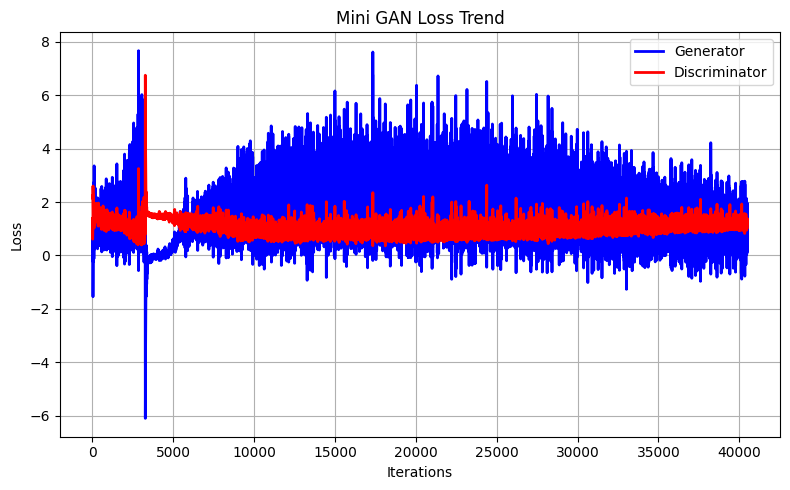

In [ ]:

iterations = list(range(1, len(losses_discriminator) + 1))

plt.figure(figsize=(8, 5))
plt.plot(iterations, losses_generator, label="Generator", color="blue", linewidth=2)
plt.plot(iterations, losses_discriminator, label="Discriminator", color="red", linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Mini GAN Loss Trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
gan_mini.save("mini_gan.pth")

Generator + Discriminator weights saved to mini_gan.pth


load GAN mini

In [ ]:
!gdown --id 1DtXWQwXM_k7hyQC_3wqT5Hv1UwAy8Ha7

gan_mini = MidiGAN.load(
    generator_class=GeneratorMini,
    discriminator_class=DiscriminatorMini,
    filepath="mini_gan.pth",
    noise_dim=512,
    sequence_length=512,
    tokenizer=tokenizer,
    gen_kwargs=generator_config,
    disc_kwargs=discriminator_config,
)


## Trainig GAN Medium

In [ ]:

generator = GeneratorMedium(**generator_config)
discriminator = DiscriminatorMedium(**discriminator_config)

gan_params = {
    "generator"                : generator,
    "discriminator"            : discriminator,
    "noise_dim"                : noise_dim,
    "sequence_length"          : seq_length,
    "tokenizer"                : tokenizer,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0) if torch.cuda.is_available() else None

sequence_length = seq_length
batch_size = batch_size
vocab_size = len(tokenizer)
normalized_tokens = normalize_data(all_ids_train, vocab_size)

print(f"Normalizzazione completata | Max: {normalized_tokens.max():.4f}, Min: {normalized_tokens.min():.4f}")

sequences = [
    normalized_tokens[i : i + sequence_length]
    for i in range(0, len(normalized_tokens) - sequence_length, sequence_length)
]

dataset = TokenDataset(sequences)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4
)

_ = torch.ones(1, device=device)
print(f"Dataset pronto. Batch size: {batch_size}, Numero batch: {len(dataloader)}")

Normalizzazione completata | Max: 0.9996, Min: -0.9988
Dataset pronto. Batch size: 128, Numero batch: 900


In [ ]:
gan_medium = MidiGAN(**gan_params)

training_arguments = {
    "dataloader"            : dataloader,
    "epochs"                : 45,
    "device"                : device,
    "steps_each_print"      : 10,
    "generator_steps"       : 1,
    "discriminator_steps"   : 1,
}

losses_discriminator, losses_generator = gan_medium.train(**training_arguments)

Starting training for 45 epochs


D Loss: 1.2473, G Loss: 0.6347: 100%|██████████| 900/900 [00:36<00:00, 24.73it/s]


Epoch 1/45 | Mean D Loss: 1.3171 | Mean G Loss: 1.1562


D Loss: 0.1822, G Loss: 3.8990: 100%|██████████| 900/900 [00:36<00:00, 24.73it/s]


Epoch 2/45 | Mean D Loss: 0.7546 | Mean G Loss: 2.1624


D Loss: 0.0311, G Loss: 6.4600: 100%|██████████| 900/900 [00:36<00:00, 24.73it/s]


Epoch 3/45 | Mean D Loss: 0.1613 | Mean G Loss: 5.3096


D Loss: 0.2550, G Loss: 6.3325: 100%|██████████| 900/900 [00:36<00:00, 24.73it/s]


Epoch 4/45 | Mean D Loss: 0.2843 | Mean G Loss: 6.1124


D Loss: 1.4941, G Loss: -0.0667: 100%|██████████| 900/900 [00:36<00:00, 24.64it/s]


Epoch 5/45 | Mean D Loss: 1.5926 | Mean G Loss: -0.0645


D Loss: 0.3627, G Loss: 3.4646: 100%|██████████| 900/900 [00:36<00:00, 24.47it/s]


Epoch 6/45 | Mean D Loss: 1.3476 | Mean G Loss: 0.6202


D Loss: 0.0233, G Loss: 6.9986: 100%|██████████| 900/900 [00:36<00:00, 24.57it/s]


Epoch 7/45 | Mean D Loss: 0.3237 | Mean G Loss: 4.9123


D Loss: 1.5352, G Loss: -0.0242: 100%|██████████| 900/900 [00:36<00:00, 24.73it/s]


Epoch 8/45 | Mean D Loss: 0.8980 | Mean G Loss: 3.0816


D Loss: 0.2202, G Loss: 2.5304: 100%|██████████| 900/900 [00:36<00:00, 24.49it/s]


Epoch 9/45 | Mean D Loss: 1.2585 | Mean G Loss: 0.8882


D Loss: 2.7181, G Loss: 2.8056: 100%|██████████| 900/900 [00:36<00:00, 24.45it/s]


Epoch 10/45 | Mean D Loss: 0.6609 | Mean G Loss: 2.8053


D Loss: 0.0832, G Loss: 6.8124: 100%|██████████| 900/900 [00:37<00:00, 24.21it/s]


Epoch 11/45 | Mean D Loss: 0.4070 | Mean G Loss: 4.9684


D Loss: 0.6300, G Loss: 6.6281: 100%|██████████| 900/900 [00:36<00:00, 24.35it/s]


Epoch 12/45 | Mean D Loss: 0.4000 | Mean G Loss: 5.8243


D Loss: 0.3809, G Loss: 8.4266: 100%|██████████| 900/900 [00:36<00:00, 24.72it/s]


Epoch 13/45 | Mean D Loss: 0.4570 | Mean G Loss: 5.3483


D Loss: 0.3459, G Loss: 6.0756: 100%|██████████| 900/900 [00:36<00:00, 24.73it/s]


Epoch 14/45 | Mean D Loss: 0.4292 | Mean G Loss: 5.4724


D Loss: 0.5889, G Loss: 4.7565: 100%|██████████| 900/900 [00:36<00:00, 24.74it/s]


Epoch 15/45 | Mean D Loss: 0.5203 | Mean G Loss: 5.3326


D Loss: 0.9267, G Loss: 2.0002: 100%|██████████| 900/900 [00:36<00:00, 24.74it/s]


Epoch 16/45 | Mean D Loss: 0.6167 | Mean G Loss: 4.8619


D Loss: 0.7748, G Loss: 6.4830: 100%|██████████| 900/900 [00:36<00:00, 24.73it/s]


Epoch 17/45 | Mean D Loss: 0.7140 | Mean G Loss: 4.1706


D Loss: 1.1394, G Loss: 3.7871: 100%|██████████| 900/900 [00:36<00:00, 24.74it/s]


Epoch 18/45 | Mean D Loss: 0.8022 | Mean G Loss: 3.6994


D Loss: 0.8199, G Loss: 3.0302: 100%|██████████| 900/900 [00:36<00:00, 24.73it/s]


Epoch 19/45 | Mean D Loss: 0.8602 | Mean G Loss: 3.1505


D Loss: 0.8789, G Loss: 3.4841: 100%|██████████| 900/900 [00:36<00:00, 24.65it/s]


Epoch 20/45 | Mean D Loss: 0.9073 | Mean G Loss: 2.8351


D Loss: 0.7745, G Loss: 2.2588: 100%|██████████| 900/900 [00:36<00:00, 24.58it/s]


Epoch 21/45 | Mean D Loss: 0.9062 | Mean G Loss: 2.7165


D Loss: 0.9069, G Loss: 3.2640: 100%|██████████| 900/900 [00:36<00:00, 24.63it/s]


Epoch 22/45 | Mean D Loss: 0.9507 | Mean G Loss: 2.5579


D Loss: 1.1948, G Loss: 2.3361: 100%|██████████| 900/900 [00:36<00:00, 24.72it/s]


Epoch 23/45 | Mean D Loss: 0.9612 | Mean G Loss: 2.4158


D Loss: 1.0822, G Loss: 1.6731: 100%|██████████| 900/900 [00:36<00:00, 24.72it/s]


Epoch 24/45 | Mean D Loss: 1.0025 | Mean G Loss: 2.1405


D Loss: 1.1016, G Loss: 3.5063: 100%|██████████| 900/900 [00:36<00:00, 24.71it/s]


Epoch 25/45 | Mean D Loss: 1.0034 | Mean G Loss: 2.0655


D Loss: 0.8361, G Loss: 2.9908: 100%|██████████| 900/900 [00:36<00:00, 24.48it/s]


Epoch 26/45 | Mean D Loss: 1.0585 | Mean G Loss: 1.8802


D Loss: 1.0182, G Loss: 1.7205: 100%|██████████| 900/900 [00:36<00:00, 24.44it/s]


Epoch 27/45 | Mean D Loss: 1.0618 | Mean G Loss: 1.7327


D Loss: 1.0493, G Loss: 1.8058: 100%|██████████| 900/900 [00:36<00:00, 24.49it/s]


Epoch 28/45 | Mean D Loss: 1.0636 | Mean G Loss: 1.6570


D Loss: 0.9114, G Loss: 2.0106: 100%|██████████| 900/900 [00:36<00:00, 24.70it/s]


Epoch 29/45 | Mean D Loss: 1.0813 | Mean G Loss: 1.6024


D Loss: 1.1937, G Loss: 0.9707: 100%|██████████| 900/900 [00:37<00:00, 24.27it/s]


Epoch 30/45 | Mean D Loss: 1.1293 | Mean G Loss: 1.4102


D Loss: 1.2539, G Loss: 0.7021: 100%|██████████| 900/900 [00:36<00:00, 24.37it/s]


Epoch 31/45 | Mean D Loss: 1.1394 | Mean G Loss: 1.3277


D Loss: 1.0981, G Loss: 1.2770: 100%|██████████| 900/900 [00:36<00:00, 24.44it/s]


Epoch 32/45 | Mean D Loss: 1.1541 | Mean G Loss: 1.2239


D Loss: 1.1548, G Loss: 0.7523: 100%|██████████| 900/900 [00:36<00:00, 24.44it/s]


Epoch 33/45 | Mean D Loss: 1.1535 | Mean G Loss: 1.1891


D Loss: 1.1613, G Loss: 0.8471: 100%|██████████| 900/900 [00:36<00:00, 24.46it/s]


Epoch 34/45 | Mean D Loss: 1.1785 | Mean G Loss: 1.1573


D Loss: 1.3694, G Loss: 2.0301: 100%|██████████| 900/900 [00:36<00:00, 24.73it/s]


Epoch 35/45 | Mean D Loss: 1.2058 | Mean G Loss: 0.9768


D Loss: 1.2354, G Loss: 0.9044: 100%|██████████| 900/900 [00:36<00:00, 24.74it/s]


Epoch 36/45 | Mean D Loss: 1.2142 | Mean G Loss: 0.9251


D Loss: 1.2819, G Loss: 0.5383: 100%|██████████| 900/900 [00:36<00:00, 24.74it/s]


Epoch 37/45 | Mean D Loss: 1.2408 | Mean G Loss: 0.8408


D Loss: 1.3061, G Loss: 0.8834: 100%|██████████| 900/900 [00:36<00:00, 24.73it/s]


Epoch 38/45 | Mean D Loss: 1.2615 | Mean G Loss: 0.7326


D Loss: 1.3064, G Loss: 0.3624: 100%|██████████| 900/900 [00:36<00:00, 24.75it/s]


Epoch 39/45 | Mean D Loss: 1.2575 | Mean G Loss: 0.7277


D Loss: 1.2710, G Loss: 0.5780: 100%|██████████| 900/900 [00:36<00:00, 24.73it/s]


Epoch 40/45 | Mean D Loss: 1.2833 | Mean G Loss: 0.6249


D Loss: 1.3261, G Loss: 0.4244: 100%|██████████| 900/900 [00:36<00:00, 24.74it/s]


Epoch 41/45 | Mean D Loss: 1.2729 | Mean G Loss: 0.6535


D Loss: 1.1062, G Loss: 0.4813: 100%|██████████| 900/900 [00:36<00:00, 24.73it/s]


Epoch 42/45 | Mean D Loss: 1.2908 | Mean G Loss: 0.5703


D Loss: 1.2961, G Loss: 0.8782: 100%|██████████| 900/900 [00:36<00:00, 24.73it/s]


Epoch 43/45 | Mean D Loss: 1.2926 | Mean G Loss: 0.5510


D Loss: 1.2531, G Loss: 0.4179: 100%|██████████| 900/900 [00:36<00:00, 24.70it/s]


Epoch 44/45 | Mean D Loss: 1.3059 | Mean G Loss: 0.5213


D Loss: 1.5175, G Loss: 0.0387: 100%|██████████| 900/900 [00:36<00:00, 24.77it/s]

Epoch 45/45 | Mean D Loss: 1.3031 | Mean G Loss: 0.4991


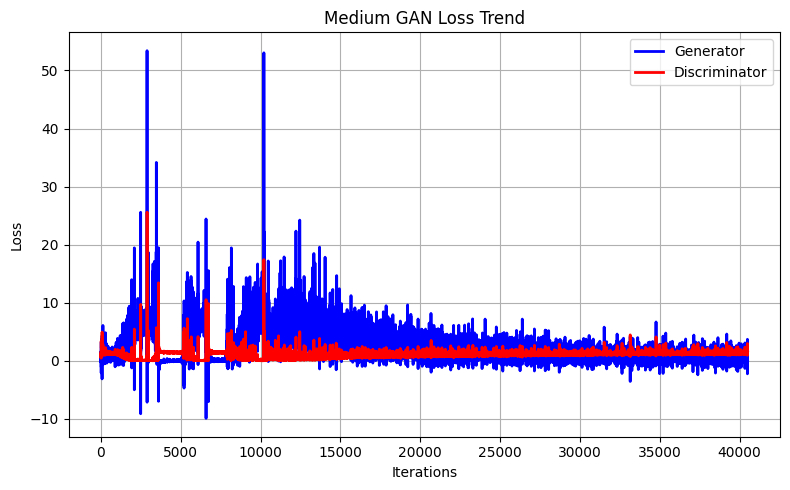

In [ ]:

iterations = list(range(1, len(losses_discriminator) + 1))

plt.figure(figsize=(8, 5))
plt.plot(iterations, losses_generator, label="Generator", color="blue", linewidth=2)
plt.plot(iterations, losses_discriminator, label="Discriminator", color="red", linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Medium GAN Loss Trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
gan_medium.save("gan_medium.pth")

Generator + Discriminator weights saved to gan_medium.pth


load GAN medium

In [ ]:
!gdown --id 1_iTzfIvq9uKgUXOnfd_TRjDiKva3vtZo

gan_medium = MidiGAN.load(
    generator_class=GeneratorMedium,
    discriminator_class=DiscriminatorMedium,
    filepath="gan_medium.pth",
    noise_dim=512,
    sequence_length=512,
    tokenizer=tokenizer,
    gen_kwargs=generator_config,
    disc_kwargs=discriminator_config,
)

## Trainig GAN Large

In [ ]:

generator = GeneratorLarge(**generator_config)
discriminator = DiscriminatorLarge(**discriminator_config)

gan_params = {
    "generator"                : generator,
    "discriminator"            : discriminator,
    "noise_dim"                : noise_dim,
    "sequence_length"          : seq_length,
    "tokenizer"                : tokenizer,
}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0) if torch.cuda.is_available() else None

sequence_length = seq_length
batch_size = batch_size
vocab_size = len(tokenizer)
normalized_tokens = normalize_data(all_ids_train, vocab_size)

print(f"Normalizzazione completata | Max: {normalized_tokens.max():.4f}, Min: {normalized_tokens.min():.4f}")

sequences = [
    normalized_tokens[i : i + sequence_length]
    for i in range(0, len(normalized_tokens) - sequence_length, sequence_length)
]

dataset = TokenDataset(sequences)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4
)

_ = torch.ones(1, device=device)
print(f"Dataset pronto. Batch size: {batch_size}, Numero batch: {len(dataloader)}")

Normalizzazione completata | Max: 0.9996, Min: -0.9988
Dataset pronto. Batch size: 128, Numero batch: 900


In [ ]:
gan_large = MidiGAN(**gan_params)

training_arguments = {
    "dataloader"            : dataloader,
    "epochs"                : 45,
    "device"                : device,
    "steps_each_print"      : 10,
    "generator_steps"       : 1,
    "discriminator_steps"   : 1,
}

losses_discriminator, losses_generator = gan_large.train(**training_arguments)

Starting training for 45 epochs


D Loss: 1.1245, G Loss: 0.4908: 100%|██████████| 900/900 [02:11<00:00,  6.82it/s]


Epoch 1/45 | Mean D Loss: 1.3321 | Mean G Loss: 0.8171


D Loss: 0.1045, G Loss: 6.4219: 100%|██████████| 900/900 [02:12<00:00,  6.81it/s]


Epoch 2/45 | Mean D Loss: 0.4848 | Mean G Loss: 3.6822


D Loss: 0.0149, G Loss: 7.9732: 100%|██████████| 900/900 [02:12<00:00,  6.82it/s]


Epoch 3/45 | Mean D Loss: 0.1689 | Mean G Loss: 6.1367


D Loss: 1.5515, G Loss: -0.1646: 100%|██████████| 900/900 [02:12<00:00,  6.82it/s]


Epoch 4/45 | Mean D Loss: 0.5202 | Mean G Loss: 5.0734


D Loss: 1.4089, G Loss: 0.0748: 100%|██████████| 900/900 [02:12<00:00,  6.81it/s]


Epoch 5/45 | Mean D Loss: 1.4233 | Mean G Loss: 0.0042


D Loss: 1.3692, G Loss: 0.1425: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 6/45 | Mean D Loss: 1.4037 | Mean G Loss: 0.0771


D Loss: 0.2654, G Loss: 2.9888: 100%|██████████| 900/900 [02:12<00:00,  6.79it/s]


Epoch 7/45 | Mean D Loss: 0.9546 | Mean G Loss: 2.1864


D Loss: 1.4122, G Loss: 0.0046: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 8/45 | Mean D Loss: 1.3563 | Mean G Loss: 0.3116


D Loss: 1.4027, G Loss: -0.0265: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 9/45 | Mean D Loss: 1.5043 | Mean G Loss: 0.0582


D Loss: 1.3802, G Loss: 0.1930: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 10/45 | Mean D Loss: 1.3954 | Mean G Loss: 0.0149


D Loss: 0.3131, G Loss: 0.4828: 100%|██████████| 900/900 [02:12<00:00,  6.79it/s]


Epoch 11/45 | Mean D Loss: 1.3070 | Mean G Loss: 0.5997


D Loss: 0.2410, G Loss: 4.1379: 100%|██████████| 900/900 [02:12<00:00,  6.79it/s]


Epoch 12/45 | Mean D Loss: 0.7059 | Mean G Loss: 3.3155


D Loss: 0.3246, G Loss: 3.5470: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 13/45 | Mean D Loss: 0.6607 | Mean G Loss: 4.3519


D Loss: 0.8190, G Loss: 2.2124: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 14/45 | Mean D Loss: 0.7830 | Mean G Loss: 3.8229


D Loss: 0.8165, G Loss: 2.2794: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 15/45 | Mean D Loss: 0.9083 | Mean G Loss: 2.9677


D Loss: 0.9812, G Loss: 3.6160: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 16/45 | Mean D Loss: 0.9019 | Mean G Loss: 2.7318


D Loss: 0.8069, G Loss: 1.7922: 100%|██████████| 900/900 [02:12<00:00,  6.79it/s]


Epoch 17/45 | Mean D Loss: 0.9022 | Mean G Loss: 2.6112


D Loss: 0.7314, G Loss: 2.5803: 100%|██████████| 900/900 [02:12<00:00,  6.77it/s]


Epoch 18/45 | Mean D Loss: 0.9319 | Mean G Loss: 2.4845


D Loss: 0.8861, G Loss: 3.3758: 100%|██████████| 900/900 [02:12<00:00,  6.77it/s]


Epoch 19/45 | Mean D Loss: 0.9932 | Mean G Loss: 2.2514


D Loss: 1.2836, G Loss: 1.0446: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 20/45 | Mean D Loss: 1.0445 | Mean G Loss: 2.0434


D Loss: 1.2493, G Loss: 1.6867: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 21/45 | Mean D Loss: 1.0600 | Mean G Loss: 1.9137


D Loss: 0.9535, G Loss: 1.8016: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 22/45 | Mean D Loss: 1.0295 | Mean G Loss: 1.8552


D Loss: 1.0646, G Loss: 1.3085: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 23/45 | Mean D Loss: 1.0552 | Mean G Loss: 1.7007


D Loss: 1.1735, G Loss: 0.7071: 100%|██████████| 900/900 [02:12<00:00,  6.78it/s]


Epoch 24/45 | Mean D Loss: 1.1234 | Mean G Loss: 1.4364


D Loss: 2.2312, G Loss: 2.6378: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 25/45 | Mean D Loss: 1.1434 | Mean G Loss: 1.2812


D Loss: 1.1684, G Loss: 1.5381: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 26/45 | Mean D Loss: 1.1884 | Mean G Loss: 1.0545


D Loss: 1.1837, G Loss: 0.7962: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 27/45 | Mean D Loss: 1.1855 | Mean G Loss: 1.0268


D Loss: 1.2073, G Loss: 3.6761: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 28/45 | Mean D Loss: 1.1989 | Mean G Loss: 0.9614


D Loss: 1.3256, G Loss: 0.6248: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 29/45 | Mean D Loss: 1.2174 | Mean G Loss: 0.8784


D Loss: 1.2901, G Loss: 0.4415: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 30/45 | Mean D Loss: 1.2554 | Mean G Loss: 0.7276


D Loss: 1.0670, G Loss: 0.7457: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 31/45 | Mean D Loss: 1.2558 | Mean G Loss: 0.6874


D Loss: 1.2430, G Loss: 0.4760: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 32/45 | Mean D Loss: 1.2629 | Mean G Loss: 0.6446


D Loss: 1.3666, G Loss: 0.2192: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 33/45 | Mean D Loss: 1.2858 | Mean G Loss: 0.5597


D Loss: 1.3251, G Loss: 0.3150: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 34/45 | Mean D Loss: 1.3063 | Mean G Loss: 0.4743


D Loss: 1.3438, G Loss: 0.2009: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 35/45 | Mean D Loss: 1.3097 | Mean G Loss: 0.4586


D Loss: 1.2961, G Loss: 0.2771: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 36/45 | Mean D Loss: 1.3229 | Mean G Loss: 0.4008


D Loss: 1.3811, G Loss: 0.2628: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 37/45 | Mean D Loss: 1.3208 | Mean G Loss: 0.3935


D Loss: 1.2546, G Loss: 0.2681: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 38/45 | Mean D Loss: 1.3268 | Mean G Loss: 0.3549


D Loss: 1.3802, G Loss: 0.2548: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 39/45 | Mean D Loss: 1.3305 | Mean G Loss: 0.3432


D Loss: 1.2561, G Loss: 0.4101: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 40/45 | Mean D Loss: 1.3285 | Mean G Loss: 0.3343


D Loss: 1.2934, G Loss: 0.3413: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 41/45 | Mean D Loss: 1.3436 | Mean G Loss: 0.2905


D Loss: 1.2917, G Loss: 0.4630: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 42/45 | Mean D Loss: 1.3548 | Mean G Loss: 0.2452


D Loss: 1.5180, G Loss: -0.4483: 100%|██████████| 900/900 [02:12<00:00,  6.78it/s]


Epoch 43/45 | Mean D Loss: 1.3512 | Mean G Loss: 0.2371


D Loss: 1.3374, G Loss: 0.1593: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]


Epoch 44/45 | Mean D Loss: 1.3557 | Mean G Loss: 0.2235


D Loss: 1.4147, G Loss: -0.0121: 100%|██████████| 900/900 [02:12<00:00,  6.80it/s]

Epoch 45/45 | Mean D Loss: 1.3581 | Mean G Loss: 0.2077


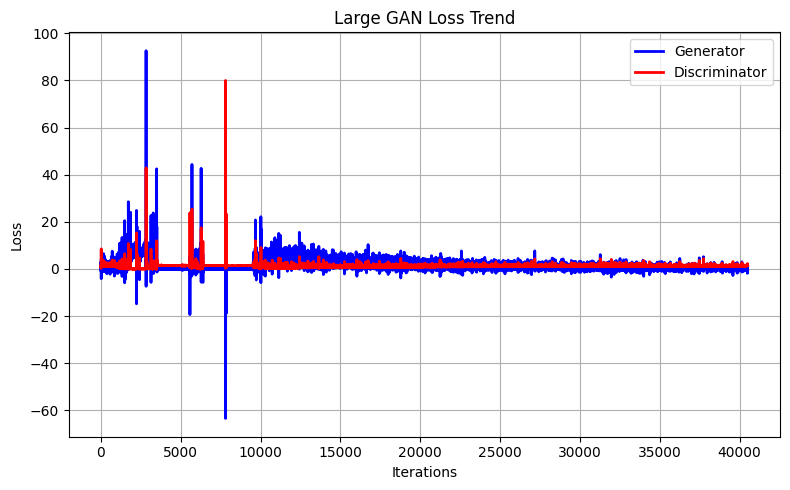

In [ ]:

iterations = list(range(1, len(losses_discriminator) + 1))

plt.figure(figsize=(8, 5))
plt.plot(iterations, losses_generator, label="Generator", color="blue", linewidth=2)
plt.plot(iterations, losses_discriminator, label="Discriminator", color="red", linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Large GAN Loss Trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
gan_large.save("gan_large.pth")

Generator + Discriminator weights saved to gan_large.pth


load GAN large

In [ ]:
!gdown 1W7JZpFX65NGmcNvp_yB8bcKM06s91C0v

gan_large = MidiGAN.load(
    generator_class=GeneratorLarge,
    discriminator_class=DiscriminatorLarge,
    filepath="gan_large.pth",
    noise_dim=512,
    sequence_length=512,
    tokenizer=tokenizer,
    gen_kwargs=generator_config,
    disc_kwargs=discriminator_config,
)

## Generate Music

Below are generated folders and 150 midi files for all 3 trained models.

In [ ]:
num_midi_files = 150

output_folder = "generated_mini"
output_prefix = f"{output_folder}/generated_midi"

os.makedirs(output_folder, exist_ok=True)

gan_mini.generate_midi(n_samples=num_midi_files, output_prefix=output_prefix, device=device)

!zip -r genereted_mini.zip generated_mini

In [ ]:
num_midi_files = 150

output_folder = "generated_medium"
output_prefix = f"{output_folder}/generated_midi"

os.makedirs(output_folder, exist_ok=True)

gan_medium.generate_midi(n_samples=num_midi_files, output_prefix=output_prefix, device=device)

!zip -r genereted_medium.zip generated_medium

In [ ]:
num_midi_files = 150

output_folder = "generated_large"
output_prefix = f"{output_folder}/generated_midi"

os.makedirs(output_folder, exist_ok=True)

gan_large.generate_midi(n_samples=num_midi_files, output_prefix=output_prefix, device=device)

!zip -r genereted_large.zip generated_large

it is possible to download the generated midi of the following

In [ ]:
!gdown --id 1WkvlkDzM3Imq4uTPb8HKlZJShtn1PALQ
!gdown --id 1pxin2tf0wmc-mIWlSC3mZOnaXKTcK6C3
!gdown --id 1hIDcYxzWmotoMZP5C8e_WFb4vGUH9cIi

!unzip genereted_mini.zip
!unzip genereted_medium.zip
!unzip genereted_large.zip

In [ ]:
!gdown --id 1ARhhdPxBfazNVg1TMkrXU1K6ce3DcOc8
!gdown --id 1VJSN9jD6HfX2nzfVhwYLfomtfOEaKXMe

!unzip dataset_test.zip
!unzip dataset_train.zip

#Performance evaluation

- Pitch_count: Measures the total number of notes in the song, indicating the overall amount of musical events.
- Note_density: Calculates the density of notes in relation to their total duration, useful for understanding how “dense” or “sparse” the musical texture is.
- Pitch_intervals: represents the average distance between consecutive notes, highlighting whether the melody proceeds with joint steps or with larger leaps.
- Pitch_range: indicates the overall range between the lowest and highest note, describing the breadth of the melodic register used.

KLD (Kullback–Leibler Divergence), which measures how much one probability distribution deviates from another, was used to compare the results of the previous metrics of the various models with the data from the dataset.

The pitch_class_histogram was also calculated, which is a metric representing the distribution of notes based on their pitch class, that is, the 12 semitones of the octave (C, C#, D, ..., B). Essentially, it counts how many times each pitch class appears in a song and normalizes its frequency.

The Rote Memorization Frequency (RM) metric measures how often repetitions of short sequences of notes present in the dataset appear in the generated midi files.

In [5]:
def pitch_count(notes):
    """
    notes: list of int (pitch values)
    """
    return len(notes)


def note_density(notes, total_duration_sec):
    """
    notes: list of notes
    total_duration_sec: duration of piece in seconds
    """
    return len(notes) / total_duration_sec if total_duration_sec > 0 else 0

def pitch_intervals(notes):
    """
    Returns average absolute pitch interval between consecutive notes
    """
    if len(notes) < 2:
        return 0
    intervals = [abs(notes[i] - notes[i-1]) for i in range(1, len(notes))]
    return np.mean(intervals)

def pitch_class_histogram(notes):
    """
    Returns normalized histogram over 12 pitch classes
    """
    histogram = [0] * 12
    for n in notes:
        pc = int(round(n)) % 12
        histogram[pc] += 1
    return histogram

def duration_sec_midi(file_path):
    _, duration = extract_notes_from_midi(file_path)
    return duration


def extract_notes_from_midi(file_path):
    midi_data = pretty_midi.PrettyMIDI(file_path)
    notes = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            notes.append(note.pitch)
    duration_sec = midi_data.get_end_time()

    return notes, duration_sec


def pitch_count_from_midi(file_path):
    notes, _ = extract_notes_from_midi(file_path)
    return pitch_count(notes)

def note_density_from_midi(file_path):
    notes, duration_sec = extract_notes_from_midi(file_path)
    return note_density(notes, duration_sec)

def pitch_intervals_from_midi(file_path):
    notes, _ = extract_notes_from_midi(file_path)
    return pitch_intervals(notes)

def pitch_range(file_path):
    """
    Calculates the pitch range of a MIDI file.
    """
    midi_data = pretty_midi.PrettyMIDI(file_path)
    all_notes = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            all_notes.append(note.pitch)
    if not all_notes:
        return 0
    pitch_max = max(all_notes)
    pitch_min = min(all_notes)
    return pitch_max - pitch_min


In [6]:

def run_function_on_folder(folder_path, func, num=0):
    """
      Runs a function (MIDI wrapper) on all MIDI files in a folder.
    """
    results = []
    midi_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".mid", ".midi"))]

    for fname in midi_files:
        file_path = os.path.join(folder_path, fname)
        try:
            if num > 0:
                result = func(file_path, num)
            else:
                result = func(file_path)
            results.append(result)
        except Exception as e:
            print(f"Error with {fname}: {e}")
            results.append(None)

    return np.array(results, dtype=object)

def average_pitch_class_histogram(folder_path):
    """Calculates the average histogram of pitch classes (0–11) as a percentage of total notes."""
    histograms = []
    total_notes = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".mid", ".midi")):
            filepath = os.path.join(folder_path, filename)
            notes, _ = extract_notes_from_midi(filepath)
            if notes:
                hist = pitch_class_histogram(notes)
                histograms.append(hist)
                total_notes += sum(hist)

    if not histograms or total_notes == 0:
        return [0] * 12

    summed_hist = np.sum(histograms, axis=0)

    percentage_hist = (summed_hist / total_notes) * 100

    return percentage_hist.tolist()

In [7]:

def extract_token_sequences(tokens, sequence_length):
    """
    Estrae tutte le sottosequenze di lunghezza fissa su GPU.
    """
    n_seqs = len(tokens) - sequence_length + 1
    if n_seqs <= 0:
        return cp.empty((0, sequence_length), dtype=cp.int32)

    return cp.stack([tokens[i:i+sequence_length] for i in range(n_seqs)])

def preprocess_real_midi_folder(real_midi_folder, sequence_length):
    """
    Estrae tutte le sottosequenze dai file MIDI reali e le restituisce come array CuPy.
    """
    all_notes_list = []

    for f in os.listdir(real_midi_folder):
        if f.lower().endswith(('.mid', '.midi')):
            path = os.path.join(real_midi_folder, f)
            notes, _ = extract_notes_from_midi(path)
            if notes:
                all_notes_list.append(cp.array(notes, dtype=cp.int32))

    if not all_notes_list:
        return cp.empty((0, sequence_length), dtype=cp.int32)

    all_notes = cp.concatenate(all_notes_list)
    sequences = extract_token_sequences(all_notes, sequence_length)
    sequences_unique = np.unique(cp.asnumpy(sequences), axis=0)
    return cp.asarray(sequences_unique, dtype=cp.int32)

def sequences_to_structured_array(seqs):
    if len(seqs) == 0:
        return cp.empty((0, seqs.shape[1]), dtype=cp.int32)
    return seqs.astype(cp.int32)

def calculate_rm_midi_preprocessed(
    generated_midi_folder: str,
    train_seqs_of_length_l: list[tuple],
    sequence_length: int
) -> float:
    """
    Calcola RM (Rote Memorization) su GPU usando sequenze reali precalcolate.
    """
    if train_seqs_of_length_l.size == 0:
        return 0.0

    train_array = cp.array(train_seqs_of_length_l, dtype=cp.int32)

    total_copied_sequences = 0
    total_sequences = 0
    all_gen_seqs = None

    for fname in tqdm(os.listdir(generated_midi_folder)):
        if fname.lower().endswith(('.mid', '.midi')):
            path = os.path.join(generated_midi_folder, fname)
            generated_notes, _ = extract_notes_from_midi(path)
            if not generated_notes:
                continue

            tokens_gpu = cp.array(generated_notes, dtype=cp.int32)
            gen_seqs = extract_token_sequences(tokens_gpu, sequence_length)

            if len(gen_seqs) == 0:
                continue

            if all_gen_seqs is None:
                all_gen_seqs = gen_seqs
            else:
                all_gen_seqs = cp.concatenate((all_gen_seqs, gen_seqs), axis=0)

    total_sequences = all_gen_seqs.shape[0]
    copied_sequences = cp.isin(gen_seqs.view(cp.int32).reshape(len(gen_seqs), -1),
                                  train_array.view(cp.int32).reshape(len(train_array), -1))

    total_copied_sequences = cp.sum(copied_sequences)

    return total_copied_sequences / total_sequences if total_sequences > 0 else 0.0


In [8]:
def kld(p, q):
    """
    Kullback-Leibler Divergence between distributions p and q
    p, q: numpy arrays representing probability distributions
    """
    p = np.asarray(p, dtype=np.float64) + 1e-12
    q = np.asarray(q, dtype=np.float64) + 1e-12
    p /= p.sum()
    q /= q.sum()
    return np.sum(rel_entr(p, q))

def make_distribution(values, bins=50, range=None):
    hist, _ = np.histogram(values, bins=bins, range=range, density=False)
    hist = hist.astype(float)
    return hist / hist.sum() if hist.sum() > 0 else hist

def real_run_function_on_folder(real_folder):
    results = {}
    real_pc = run_function_on_folder(real_folder, pitch_count_from_midi)
    real_nd = run_function_on_folder(real_folder, note_density_from_midi)
    real_pi = run_function_on_folder(real_folder, pitch_intervals_from_midi)
    real_pr = run_function_on_folder(real_folder, pitch_range)
    real_ds = run_function_on_folder(real_folder, duration_sec_midi)

    results["pitch_count"] = real_pc
    results["note_density"] = real_nd
    results["pitch_intervals"] = real_pi
    results["pitch_range"] = real_pr
    results["duration_sec"] = real_ds

    return results

def compare_folders_with_kld(real_result, generated_result, range):
    results_kld = {}

    results_kld["pitch_count"] = kld(make_distribution(real_result["pitch_count"], 50, range["pitch_count"]), make_distribution(generated_result["pitch_count"], 50, range["pitch_count"]))

    results_kld["note_density"] = kld(make_distribution(real_result["note_density"], 50, range["note_density"]), make_distribution(generated_result["note_density"], 50, range["note_density"]))

    results_kld["pitch_intervals"] = kld(make_distribution(real_result["pitch_intervals"], 50, range["pitch_intervals"]), make_distribution(generated_result["pitch_intervals"], 50, range["pitch_intervals"]))

    results_kld["pitch_range"] = kld(make_distribution(real_result["pitch_range"], 50, range["pitch_range"]), make_distribution(generated_result["pitch_range"], 50, range["pitch_range"]))

    return results_kld

def calculate_range(real_result, generated_mini_result, generated_medium_result, generated_large_result):
    result = {}
    for key in real_result:
        values = [
            (min(real_result[key]), max(real_result[key])),
            (min(generated_mini_result.get(key)), max(generated_mini_result.get(key))),
            (min(generated_medium_result.get(key)), max(generated_medium_result.get(key))),
           ( min(generated_large_result.get(key)), max(generated_large_result.get(key))),
        ]
        min_val = min(v[0] for v in values)
        max_val = max(v[1] for v in values)
        result[key] = (min_val, max_val)
    return result




metric calculation

In [ ]:
generated_mini_folder = "/content/generated_mini"
generated_medium_folder = "/content/generated_medium"
generated_large_folder = "/content/generated_large"
real_folder_train = "/content/dataset_train"
real_folder_test = "/content/dataset_test"

real_result_train = real_run_function_on_folder(real_folder_train)

results_mini = real_run_function_on_folder(generated_mini_folder)
results_medium = real_run_function_on_folder(generated_medium_folder)
results_large = real_run_function_on_folder(generated_large_folder)

range_mini = calculate_range(real_result_train, results_mini, results_medium, results_large)
range_medium = calculate_range(real_result_train, results_medium, results_mini, results_large)
range_large = calculate_range(real_result_train, results_large, results_mini, results_medium)

results_mini_kld_train = compare_folders_with_kld(real_result_train, results_mini, range_mini)
results_medium_kld_train = compare_folders_with_kld(real_result_train, results_medium, range_medium)
results_large_kld_train = compare_folders_with_kld(real_result_train, results_large, range_large)

real_result_test = real_run_function_on_folder(real_folder_test)

range_mini = calculate_range(real_result_test, results_mini, results_medium, results_large)
range_medium = calculate_range(real_result_test, results_medium, results_mini, results_large)
range_large = calculate_range(real_result_test, results_large, results_mini, results_medium)

results_mini_kld_test = compare_folders_with_kld(real_result_test, results_mini, range_mini)
results_medium_kld_test = compare_folders_with_kld(real_result_test, results_medium, range_medium)
results_large_kld_test = compare_folders_with_kld(real_result_test, results_large, range_large)

print("Result real train:\n")
for key, value in real_result_train.items():
  mean_val = np.mean(value)
  print(f"{key} = {mean_val:.4f}")

print("\nResult real test:\n")
for key, value in real_result_test.items():
  mean_val = np.mean(value)
  print(f"{key} = {mean_val:.4f}")

print("\nResult mini:\n")
for key, value in results_mini.items():
  mean_val = np.mean(value)
  print(f"{key} = {mean_val:.4f}")

print("\nResult medium:\n")
for key, value in results_medium.items():
  mean_val = np.mean(value)
  print(f"{key} = {mean_val:.4f}")

print("\nResult large:\n")
for key, value in results_large.items():
  mean_val = np.mean(value)
  print(f"{key} = {mean_val:.4f}")

print("\n\n")
print("KLD result:\n")

print("Result mini/train:\n")
for key, value in results_mini_kld_train.items():
  print(f"{key}: KLD = {value:.4f}")

print("\nResult medium/train:\n")
for key, value in results_medium_kld_train.items():
  print(f"{key}: KLD = {value:.4f}")

print("\nResult large/train:\n")
for key, value in results_large_kld_train.items():
  print(f"{key}: KLD = {value:.4f}")

print("Result mini/test:\n")
for key, value in results_mini_kld_test.items():
  print(f"{key}: KLD = {value:.4f}")

print("\nResult medium/test:\n")
for key, value in results_medium_kld_test.items():
  print(f"{key}: KLD = {value:.4f}")

print("\nResult large/test:\n")
for key, value in results_large_kld_test.items():
  print(f"{key}: KLD = {value:.4f}")

Result real train:

pitch_count = 5476.6836
note_density = 10.4896
pitch_intervals = 11.5350
pitch_range = 68.1361
duration_sec = 549.4486

Result real test:

pitch_count = 5680.2745
note_density = 9.8108
pitch_intervals = 11.4376
pitch_range = 68.1843
duration_sec = 609.3147

Result mini:

pitch_count = 296.2933
note_density = 3.0941
pitch_intervals = 16.0579
pitch_range = 72.9200
duration_sec = 102.4010

Result medium:

pitch_count = 291.0267
note_density = 3.0092
pitch_intervals = 15.9638
pitch_range = 72.7733
duration_sec = 104.0546

Result large:

pitch_count = 270.3600
note_density = 2.9339
pitch_intervals = 16.0622
pitch_range = 72.8267
duration_sec = 99.0456



KLD result:

Result mini/train:

pitch_count: KLD = 24.2707
note_density: KLD = 22.0168
pitch_intervals: KLD = 23.2719
pitch_range: KLD = 8.4655

Result medium/train:

pitch_count: KLD = 24.2707
note_density: KLD = 21.7510
pitch_intervals: KLD = 22.6902
pitch_range: KLD = 7.9767

Result large/train:

pitch_count: KLD = 2

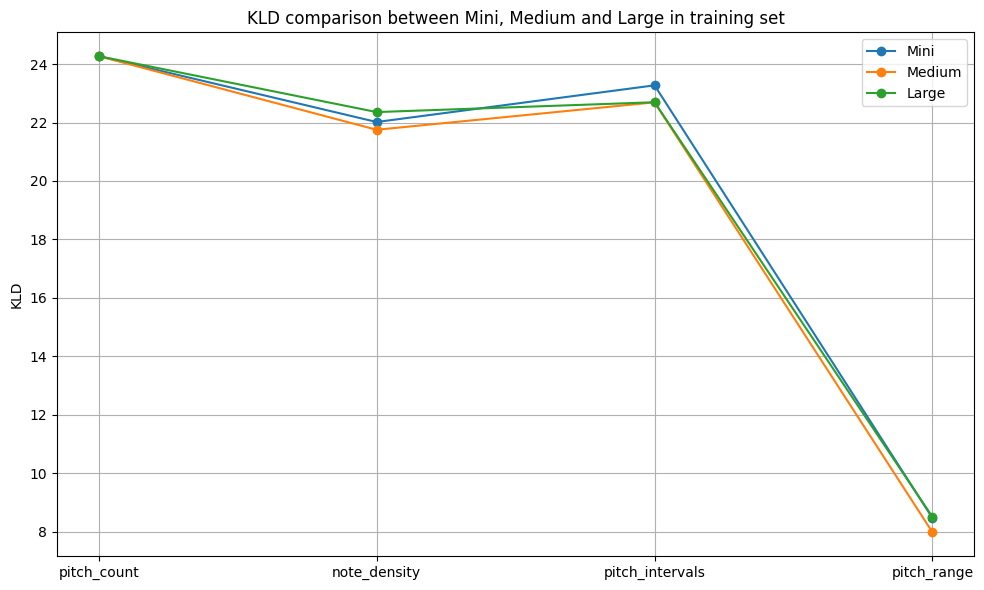

In [ ]:
metrics = list(results_mini_kld_train.keys())
values_mini = list(results_mini_kld_train.values())
values_medium = list(results_medium_kld_train.values())
values_large = list(results_large_kld_train.values())

plt.figure(figsize=(10,6))
plt.plot(metrics, values_mini, marker="o", label="Mini")
plt.plot(metrics, values_medium, marker="o", label="Medium")
plt.plot(metrics, values_large, marker="o", label="Large")

plt.ylabel("KLD")
plt.title("KLD comparison between Mini, Medium and Large in training set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

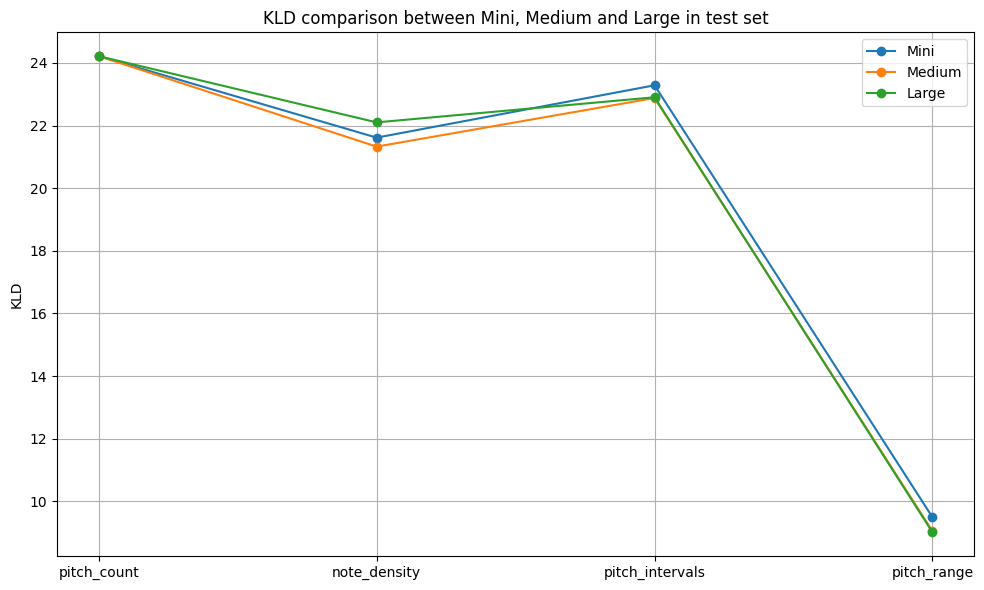

In [ ]:
metrics = list(results_mini_kld_test.keys())
values_mini = list(results_mini_kld_test.values())
values_medium = list(results_medium_kld_test.values())
values_large = list(results_large_kld_test.values())

plt.figure(figsize=(10,6))
plt.plot(metrics, values_mini, marker="o", label="Mini")
plt.plot(metrics, values_medium, marker="o", label="Medium")
plt.plot(metrics, values_large, marker="o", label="Large")

plt.ylabel("KLD")
plt.title("KLD comparison between Mini, Medium and Large in test set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Below is the calculated Rote Memorization Frequency of the midi generated by the various models on sequences of length of 3 and 5 notes.

In [ ]:
train_seqs_5 = preprocess_real_midi_folder("dataset_train/", sequence_length=5)
train_seqs_3 = preprocess_real_midi_folder("dataset_train/", sequence_length=3)
rm_mini_5 = calculate_rm_midi_preprocessed("generated_mini/", train_seqs_5, sequence_length=5)
rm_mini_3 = calculate_rm_midi_preprocessed("generated_mini/", train_seqs_3, sequence_length=3)
print("Rote Memorization Frequency in training set: \n")
print("Rote Memorization Frequency mini: \n")
print("Rote Memorization Frequency 3:", rm_mini_3 * 100, "%")
print("Rote Memorization Frequency 5:", rm_mini_5 * 100, "%")
rm_medium_5 = calculate_rm_midi_preprocessed("generated_medium/", train_seqs_5, sequence_length=5)
rm_medium_3 = calculate_rm_midi_preprocessed("generated_medium/", train_seqs_3, sequence_length=3)
print("Rote Memorization Frequency medium: \n")
print("Rote Memorization Frequency 3:", rm_medium_3 * 100, "%")
print("Rote Memorization Frequency 5:", rm_medium_5 * 100, "%")
rm_large_5 = calculate_rm_midi_preprocessed("generated_large/", train_seqs_5, sequence_length=5)
rm_large_3 = calculate_rm_midi_preprocessed("generated_large/", train_seqs_3, sequence_length=3)
print("Rote Memorization Frequency large: \n")
print("Rote Memorization Frequency 3:", rm_large_3 * 100, "%")
print("Rote Memorization Frequency 5:", rm_large_5 * 100, "%")

100%|██████████| 150/150 [00:01<00:00, 96.60it/s] 


Rote Memorization Frequency in training set: 

Rote Memorization Frequency mini: 

Rote Memorization Frequency 3: 1.6446176150779268 %
Rote Memorization Frequency 5: 2.736976553234194 %


100%|██████████| 150/150 [00:01<00:00, 98.79it/s] 


Rote Memorization Frequency medium: 

Rote Memorization Frequency 3: 3.010102874013932 %
Rote Memorization Frequency 5: 5.028568774097645 %


100%|██████████| 150/150 [00:01<00:00, 104.60it/s]

Rote Memorization Frequency large: 

Rote Memorization Frequency 3: 1.833358175585035 %
Rote Memorization Frequency 5: 3.0535115382690092 %


In [9]:
train_seqs_5 = preprocess_real_midi_folder("dataset_test/", sequence_length=5)
train_seqs_3 = preprocess_real_midi_folder("dataset_test/", sequence_length=3)
rm_mini_5 = calculate_rm_midi_preprocessed("generated_mini/", train_seqs_5, sequence_length=5)
rm_mini_3 = calculate_rm_midi_preprocessed("generated_mini/", train_seqs_3, sequence_length=3)
print("Rote Memorization Frequency in testing set: \n")
print("Rote Memorization Frequency mini: \n")
print("Rote Memorization Frequency 3:", rm_mini_3 * 100, "%")
print("Rote Memorization Frequency 5:", rm_mini_5 * 100, "%")
rm_medium_5 = calculate_rm_midi_preprocessed("generated_medium/", train_seqs_5, sequence_length=5)
rm_medium_3 = calculate_rm_midi_preprocessed("generated_medium/", train_seqs_3, sequence_length=3)
print("Rote Memorization Frequency medium: \n")
print("Rote Memorization Frequency 3:", rm_medium_3 * 100, "%")
print("Rote Memorization Frequency 5:", rm_medium_5 * 100, "%")
rm_large_5 = calculate_rm_midi_preprocessed("generated_large/", train_seqs_5, sequence_length=5)
rm_large_3 = calculate_rm_midi_preprocessed("generated_large/", train_seqs_3, sequence_length=3)
print("Rote Memorization Frequency large: \n")
print("Rote Memorization Frequency 3:", rm_large_3 * 100, "%")
print("Rote Memorization Frequency 5:", rm_large_5 * 100, "%")

100%|██████████| 150/150 [00:01<00:00, 146.75it/s]


Rote Memorization Frequency in testing set: 

Rote Memorization Frequency mini: 

Rote Memorization Frequency 3: 1.9096592968466837 %
Rote Memorization Frequency 5: 3.1817352431347508 %


100%|██████████| 150/150 [00:01<00:00, 149.72it/s]


Rote Memorization Frequency medium: 

Rote Memorization Frequency 3: 1.5915486460303547 %
Rote Memorization Frequency 5: 2.64783759929391 %


100%|██████████| 150/150 [00:00<00:00, 159.42it/s]

Rote Memorization Frequency large: 

Rote Memorization Frequency 3: 2.161275898047399 %
Rote Memorization Frequency 5: 3.604144766481453 %


the following graph shows the pitch_class_histogram of the midi of the various models and that of the dataset

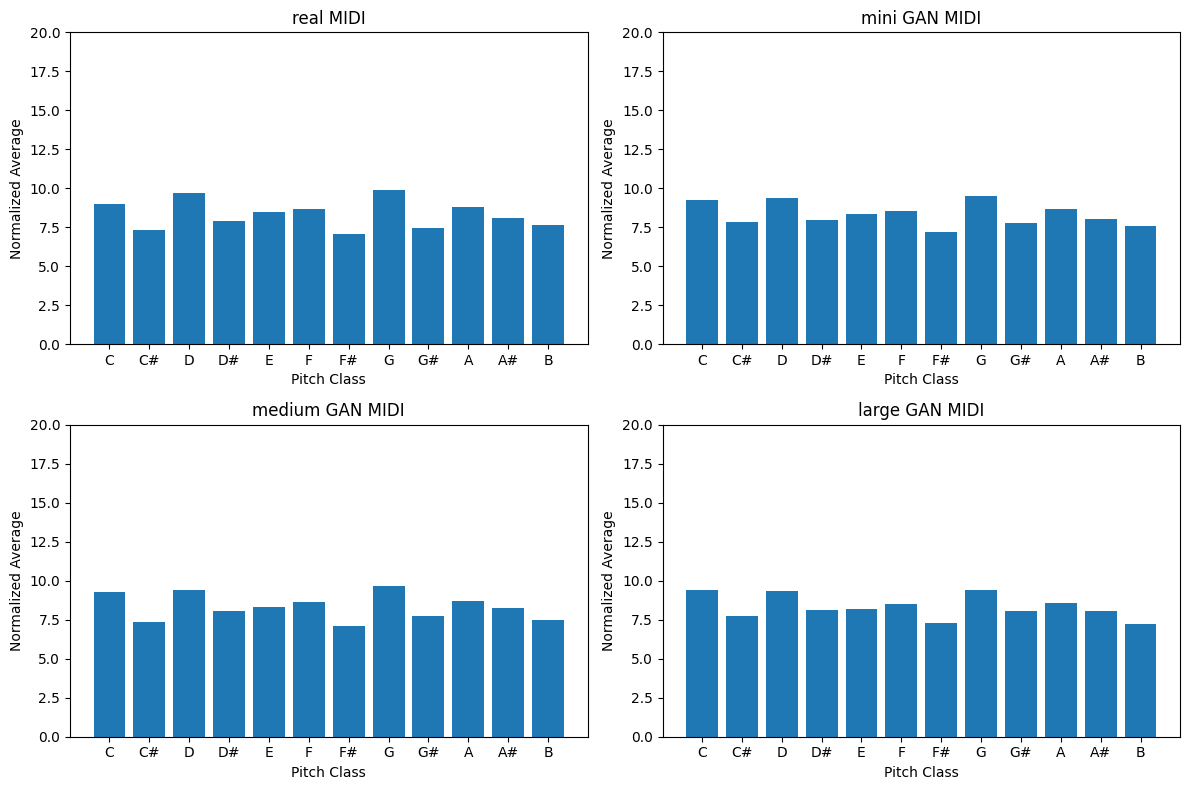

In [ ]:
def plot_histograms(folders, labels):
    pitch_classes = ["C", "C#", "D", "D#", "E", "F",
                     "F#", "G", "G#", "A", "A#", "B"]

    plt.figure(figsize=(12, 8))

    for i, folder in enumerate(folders):
        avg_hist = average_pitch_class_histogram(folder)
        plt.subplot(2, 2, i + 1)
        plt.bar(pitch_classes, avg_hist)
        plt.title(labels[i])
        plt.xlabel("Pitch Class")
        plt.ylabel("Normalized Average")
        plt.ylim(0, 20)

    plt.tight_layout()
    plt.show()

folders = [
    "/content/dataset_test",
    "/content/generated_mini",
    "/content/generated_medium",
    "/content/generated_large"
]
labels = ["real MIDI", "mini GAN MIDI", "medium GAN MIDI", "large GAN MIDI"]

plot_histograms(folders, labels)

KLD calculation of pitch_class_histogram

In [ ]:
real_pch = average_pitch_class_histogram("/content/dataset_test")
mini_pch = average_pitch_class_histogram("/content/generated_mini")
medium_pch = average_pitch_class_histogram("/content/generated_medium")
large_pch = average_pitch_class_histogram("/content/generated_large")

kld_real_mini = kld(real_pch, mini_pch)
kld_real_medium = kld(real_pch, medium_pch)
kld_real_large = kld(real_pch, large_pch)

print("KLD real vs mini:", kld_real_mini)
print("KLD real vs medium:", kld_real_medium)
print("KLD real vs large:", kld_real_large)

KLD real vs mini: 0.0004852913783066463
KLD real vs medium: 0.00019788395321181053
KLD real vs large: 0.0009136427626746622
